# Homework  Task

In module 9 we learned how to solve a problem from end to end using SKLearn and pipelines. There we learned how to  predict house prices in California.
In this homework, we adopt this end to end pipeline to tackle the Titanic Survival problem.
Adopt the machine learning pipeline above to tackle the Titanic problem. 
## Submission instructions
1. Before completing this homework,
    * please review this homework's submission form on Canvas available under the "Modules" menu option and 
    * briefly review this notebook end to end. 
* To get you started we provide a template solution with missing code and prompts. Please complete the missing code, run the experiments and log your results.
* When you're sufficiently happy with your results, please begin the submission process on Canvas. Use the submission form for this homework available under "Modules" menu option. Please note that the submission form is available at the same place where you downloaded the homework from.
* You may wish to reference this quiz while working through the tasks.

You will need to:

* __Important:__ To ensure the accuracy of your results (for the quiz) you must split the data using a 20% test set with random seed = 42.
* __EDA.__ Identify the types of data available, evaluate basic statistical information about the data and determine whether you have any missing or misformated data.

* __Feature Engineering.__  Develop at least one new feature.  The following [webpage](http://trevorstephens.com/kaggle-titanic-tutorial/r-part-4-feature-engineering/) has some great ideas for creating new features on the Titanic dataset.
* __Pre-processing.__  All work must be performed using pipelines.  You can adapt code from above or develop your own.
* __Modeling.__Evaluate at least two appropriate algorithms (estimators) for generating predictions.
    * Use grid search to tune hyperparameters.
    * Use crossfold evaluation (cv=5).
* __Evaluation.__ Select appropriate metrics for the problem to evaluate your models.
* __Reporting.__ Record all experiments in a table of results (pandas dataframe) including at least the following information:  
    * description of the model (algorithim, notable processing steps) 
    * key hyperparameters
    * results (using one or more appropriate metrics)
    * run time for each experiment (train and test results)
    * hardware used
* __Analysis__. Perform a significance test on your best models and discuss results (see Module 09.5 in Canvas for a video lecture on significance testing).

Your final pipeline will take the following format:

<PRE>
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),  # combination of numerical and categorical pipelines
        ("logRegression", LogisticRegression())  # replace with whatever estimator(s) you are using
    ])

</PRE>


# Prepare the notebook (imports, helper functions, etc.)

In [306]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [307]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [308]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

In [309]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# Data import and EDA

In [310]:
data = pd.read_csv('datasets/titanic/train.csv')
y = data['Survived']
x = data.drop(['Survived', 'Ticket', 'Cabin'], axis = 1)

In [311]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [313]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [314]:
# Show the correlation of the Survived column with the features
corr_matrix = data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

## Correlation Observations
The goal of this section is to get familiar with the data that will be used for the end to end pipeline. It is very important to explore the data and summarize its main characteristics before diving in the machine learning models. It is also interesting to see how the different features are correlated with the target feature

* *Fare* and *Pclass* are the most highly correlated with survivorship. A higher fare indicates a higher chance of surviving; a lower class (where "first" class is better than "third") indicates a higher chance of survinging. 
* *Sex* and *Embarked* do not appear in the correlation list, because they are not numeric values. We can one-hot encode this column and re-examine later.

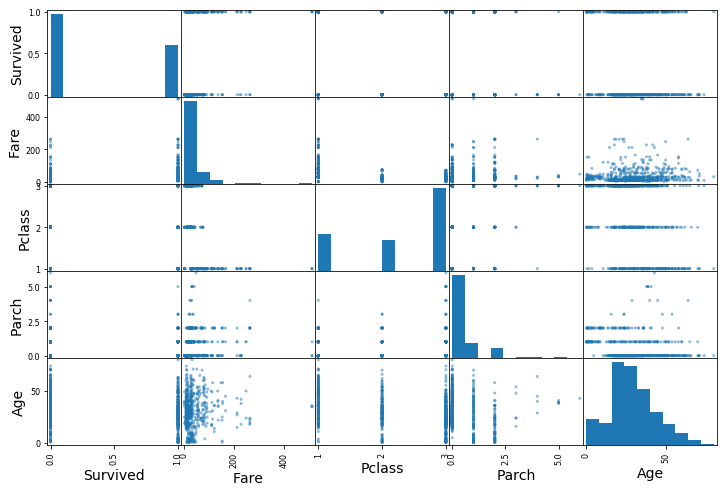

In [315]:
from pandas.plotting import scatter_matrix

# Top four correlated inputs with survived
attributes = ["Survived", "Fare", "Pclass", "Parch", "Age"]
scatter_matrix(data[attributes], figsize=(12, 8));

## Evaluate categorical features with respect to Survived

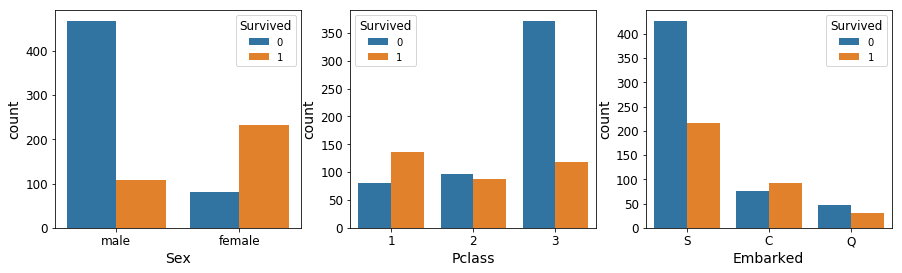

In [316]:
cat_vars = ['Sex', 'Pclass', 'Embarked']
plt.figure(figsize=(15,4))
for idx, cat in enumerate(cat_vars):
    plt.subplot(1, 3, idx+1)
    sns.countplot(data[cat], hue=data['Survived'])

In [317]:
np.random.seed(42)
# split 20% test data with random seed set to 42 for correct results
# and shuffle the dataset
#==================================================#
#               Your code starts here              #
#==================================================#
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True) 

#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#

# Build processing pipelines
In this part of the homework the focus is on constructing the pipeline. Since the data has both numerical and categorical features, it is required to create two pipelines (one for each category of data) because they require different transformations. After finishing that, the two pipelines should be unified to produce one full pipeline that performs transformation on all the dataset

# Feature Engineering
When conducting an end to end Machine Learning project, after exploring and preprocessing the data it is essential to think of feature engineering. It consists of creating new feature(s) based on the features that already exist in the dataset that can be useful for training the model.

## Develop a new feature based on the title from each passengers name

### Evaluate the distribution of titles

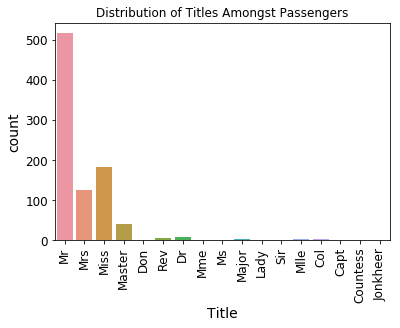

In [319]:
data['Title'] = data['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data)
plt.title('Distribution of Titles Amongst Passengers')
plt.xticks(rotation=90);

### Consolidate special and miscellaneous titles
Most titles fall into one of four categories (Mr, Mrs., Miss, Master).  All other titles can be combined with one of these groups (i.e., they are French varients) or grouped as "other". 

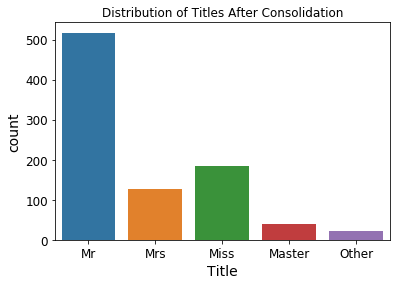

In [320]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr','Major', 'Lady', 'Sir', 
                                       'Col', 'Capt', 'Countess', 'Jonkheer'],'Other')
sns.countplot(x='Title', data=data);
plt.title('Distribution of Titles After Consolidation');

In [321]:
data.groupby('Title').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Title,,,,,,,,,,,,
Master,40,40,40,40,40,36,40,40,40,40,7,40
Miss,185,185,185,185,185,149,185,185,185,185,49,184
Mr,517,517,517,517,517,398,517,517,517,517,93,517
Mrs,126,126,126,126,126,109,126,126,126,126,45,125
Other,23,23,23,23,23,22,23,23,23,23,10,23


## Create a transformer to perfom this new feature transformation in a pipeline

In [322]:
class TitleAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        df = pd.DataFrame(X, columns=self.features)
        df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
        # Apply the necessary transformations to obtain the 5 title categories
        # (Mr, Mrs, Miss, Master, Other) like it was done in section 5.1.2
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        
        df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
        df['Title'] = df['Title'].replace(['Don', 'Dona', 'Rev', 'Dr','Major', 'Lady', 'Sir', 
                                       'Col', 'Capt', 'Countess', 'Jonkheer'],'Other')
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#
        df.drop('Name', axis=1, inplace=True)
        return np.array(df.values)

In [318]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer

# Identify the numeric features we wish to consider. 
num_attribs = [
    'Age', 
    'Parch', 
    'SibSp',
    'Fare'
]
# Create a pipeline for the numeric features.
# Use DataFrameSelector with the numeric features defined above
# Use StandardScaler() to standardize the data
# Missing values will be imputed using the feature median.
#==================================================#
#               Your code starts here              #
#==================================================#      
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#


# Identify the categorical features we wish to consider.
cat_attribs = [
    "Embarked", 
    "Sex",
    'Pclass'
]
# Identiy the range of expected values for the categorical features.
cat_values = [
    ['S','C','Q'],     # Embarked
    ['female','male'], # Sex
    [1,2,3] # Pclass
]
# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

# Union the transformed, scaled numeric and categorical features.
#==================================================#
#               Your code starts here              #
#==================================================#

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#



# Modeling
Now that we have explored the data, cleaned it, preprocessed it and added a new feature to it, we can start the modeling part of the project by applying Machine Learning algorithms. In this section, you will have a baseline logistic regression model and grid searches on different models. In the end, you will find out which parameters are the best for each algorithm and you will be able to compare the performance of the models with the baseline model.
## Baseline Logistic Regression

In [324]:
y = data['Survived']
x = data.drop(['Survived', 'Ticket', 'Cabin'], axis = 1)

In [325]:
# use full pipeline above to build full pipeline with predictor
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("logRegression", LogisticRegression())
    ])

# split 20% test data with random seed set to 42 for correct results
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=42)

In [333]:
start = time()
full_pipeline_with_predictor.fit(x_train, y_train)
np.random.seed(42)

# Set up cross validation scores 
# Use ShuffleSplit() with 30 splits, 30% test_size 
# and a random seed of 0
#==================================================#
#               Your code starts here              #
#==================================================#
cv30Splits = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
     
logit_scores = cross_val_score(full_pipeline_with_predictor, x_train, y_train,
                         scoring= None , cv=cv30Splits)
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(x_test, y_test)
test_time = np.round(time() - start, 4)

In [334]:
results.loc[0] = ["Baseline", pct(logit_score_train), np.round(pct(logit_score_test),3), 
                  "---", train_time, test_time, "Untuned LogisticRegression"]
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,79.6,79.9,---,0.6563,0.005,Untuned LogisticRegression
1,Best Model:Logistic Regression,79.9,79.9,0.05041,0.0080,0.003,"[[""predictor__C"", 0.1], [""predictor__penalty"",..."
2,Best Model:K-Nearest Neighbors,80.4,83.2,0.03147,0.0070,0.010,"[[""predictor__n_neighbors"", 11], [""predictor__..."
3,Best Model:Naive Bayes,78.0,77.1,0.00017,0.0070,0.003,[]
4,Best Model:Support Vector,81.9,81.6,0,0.0200,0.005,"[[""predictor__C"", 1], [""predictor__degree"", 1]..."
5,Best Model:Stochastic GD,79.8,79.9,0.2953,0.0100,0.003,"[[""predictor__alpha"", 0.01], [""predictor__loss..."
6,Best Model:RandomForest,80.5,81.6,0.00763,0.0240,0.005,"[[""predictor__bootstrap"", false], [""predictor_..."


## Conduct Grid Search using a variety of Classification Algorithms

In this section, we're going to try to answer the following questions
Note: These questions should be answered in Canvas once you have completed this section.
### Best train accuracy
    Please submit the code snippet you added to calculate the best train accuracy in the section below of the notebook
### Best parameters for Logistic Regression 
    Based on the results obtained after conducting Grid Search in this section , choose the best parameters for Logistic Regression
### Best parameters for k-nearest neighbors
    Based on the results obtained after conducting Grid Search in this section, what is  the best parameter for n_neighbors for k-nearest neighbors?
### SVM Test Accuracy
Please enter the calculated value for test Accuracy of Support vector model in the section below of the notebook. 
(Report your number to 1 decimal point of precision. For example: 2.5)
### Statistical significance
    Which one of the models listed below is the most statistically significant based on the results of this section? 
    * Naive Bayes
    * Stochastic GD
    * RandomForest
    * Logistic Regression
### Choosing the best model
    Given the results that you obtained for the different models in this section, based on what information would you choose the best model to deploy? 
    * Cross fold Train Accuracy
    * Test Accuracy
    * p-value
    * Train Time
    * Test Time
 
    

In [335]:

# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Support Vector', SVC(random_state=42)),
        ('Stochastic GD', SGDClassifier(random_state=42)),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01),
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2),
        },
        'Naive Bayes': {},
        'Support Vector' : {
            'kernel': ('rbf', 'poly'),     
            'degree': (1, 2, 3, 4, 5),
            'C': (10, 1, 0.1, 0.01),
        },
        'Stochastic GD': {
            'loss': ('hinge', 'perceptron', 'log'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        #best_train_scores = cross_val_score( ...., cv=cv30Splits)
        best_train_scores = cross_val_score(grid_search.best_estimator_ ,X_train, y_train, cv=cv30Splits)
        best_train_accuracy = pct(best_train_scores.mean())     
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#    
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,5), train_time, test_time, json.dumps(param_dump)]

In [336]:
%%time
# This might take a while
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    ConductGridSearch(x_train, y_train, x_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.6s finished


Best Parameters:
	predictor__C: 0.1
	predictor__penalty: l2
	predictor__tol: 0.0001
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (3, 5, 7, 8, 11)
	p: (1, 2)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished


Best Parameters:
	predictor__n_neighbors: 11
	predictor__p: 1
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Naive Bayes *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Best Parameters:
****** FINISH Best Model: Naive Bayes  *****

****** START Best Model: Support Vector *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	degree: (1, 2, 3, 4, 5)
	kernel: ('rbf', 'poly')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.9s finished


Best Parameters:
	predictor__C: 1
	predictor__degree: 1
	predictor__kernel: rbf
****** FINISH Best Model: Support Vector  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('hinge', 'perceptron', 'log')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    9.4s finished


Best Parameters:
	predictor__alpha: 0.01
	predictor__loss: log
	predictor__penalty: elasticnet
	predictor__tol: 0.0001
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed:  8.9min finished


Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 26
	predictor__max_features: 5
	predictor__min_samples_leaf: 10
	predictor__min_samples_split: 10
	predictor__n_estimators: 20
****** FINISH Best Model: RandomForest  *****

Wall time: 9min 12s


In [331]:
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,79.6,79.9,---,0.415,0.004,Untuned LogisticRegression
1,Best Model:Logistic Regression,79.9,79.9,0.05041,0.008,0.003,"[[""predictor__C"", 0.1], [""predictor__penalty"",..."
2,Best Model:K-Nearest Neighbors,80.4,83.2,0.03147,0.007,0.010,"[[""predictor__n_neighbors"", 11], [""predictor__..."
3,Best Model:Naive Bayes,78.0,77.1,0.00017,0.007,0.003,[]
4,Best Model:Support Vector,81.9,81.6,0,0.020,0.005,"[[""predictor__C"", 1], [""predictor__degree"", 1]..."
5,Best Model:Stochastic GD,79.8,79.9,0.2953,0.010,0.003,"[[""predictor__alpha"", 0.01], [""predictor__loss..."
6,Best Model:RandomForest,80.5,81.6,0.00763,0.024,0.005,"[[""predictor__bootstrap"", false], [""predictor_..."


## Observations

* The Support Vector Classifier with parameters [C=1, degree=1, kernel=rbf] had the best overall performance followed by the Random Forest classifier. The p-values of 0.000 and 0001, respectively, indicate that both results are signficantly different from the baseline Logistic Regression model. 
* There tuned Logistic Regression was not statistically different than the baseline (untuned) model.

# OPTIONAL: TMDB Box Office Prediction on Kaggle

 For this part of the homework 
You will need to look at the  [TMDB Box Office Prediction Competition on Kaggle](https://www.kaggle.com/c/tmdb-box-office-prediction)
Through the lectures and lab we learned how to predict house prices in California. In this homework, we adopted  the end to end pipeline to tackle the Titanic Survival problem. Now, we want you to adopt the machine learning pipeline to tackle the TMDB Box Office Prediction

In this dataset, you are provided with 7,398  movies (3,000 for training and 4,398 for testing) and a variety of metadata obtained from The Movie Database (TMDB). Movies are labeled with id. Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.

Feel free to use the [Kaggle API](https://github.com/Kaggle/kaggle-api) for downloading the dataset or submitting to the competition. It is not mandatory to use the package but it would be interesting to explore.
   You will need to: 
* __Important:__ Make sure your results are reproducible 
* __Important:__ Use the training data set provided by the competition to create a training set(70%), validation set (15%) and a test set (15%)
* __EDA.__ Identify the types of data available, evaluate basic statistical information about the data and determine whether you have any missing or misformated data.

* __Feature Engineering.__  Develop at least one new feature based on the existing features of the dataset
* __Pre-processing.__  All work must be performed using pipelines.  You can adapt code from above or develop your own.
* __Modeling.__Evaluate at least two appropriate algorithms (estimators) for generating predictions.
    * Use grid search to tune hyperparameters.
    * Use crossfold evaluation (cv=5).
* __Evaluation.__ Select appropriate metrics for the problem to evaluate your models.
* __Reporting.__ Record all experiments in a table of results (pandas dataframe) including at least the following information:  
    * description of the model (algorithim, notable processing steps) 
    * key hyperparameters
    * results (using one or more appropriate metrics)
    * run time for each experiment (train and test results)
    * hardware used
* __Analysis__. Perform a significance test on your best models and discuss results (see Module 09.5 in Canvas for a video lecture on significance testing).
* __Submit your best model to Kaggle__ Provide a screenshot of the kaggle submission
* __Comment your code and provide explanations of how you're proceeding in each part__


## Data Import & notebook preperation


In [264]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


In [265]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [266]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Set up ShuffleSplit for p_value testing
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

In [267]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

In [268]:
data = pd.read_csv('datasets/TMDB/train.csv')
#y = data ['revenue']
data = data .drop(['belongs_to_collection', 'homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'tagline', 'cast', 'crew'], axis = 1)
test_data = pd.read_csv('datasets/TMDB/test.csv')


* __Important:__ Remember that x and y should be split into a training set (70% of the original dataset), a validation set (15% of the original dataset) and a test set (15% of the original dataset. 
* test_data will be only used for the kaggle submission

## EDA

In [269]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [270]:
data.dropna(subset=["genres", "Keywords", "production_countries", "production_companies","runtime", "spoken_languages" ], inplace=True)

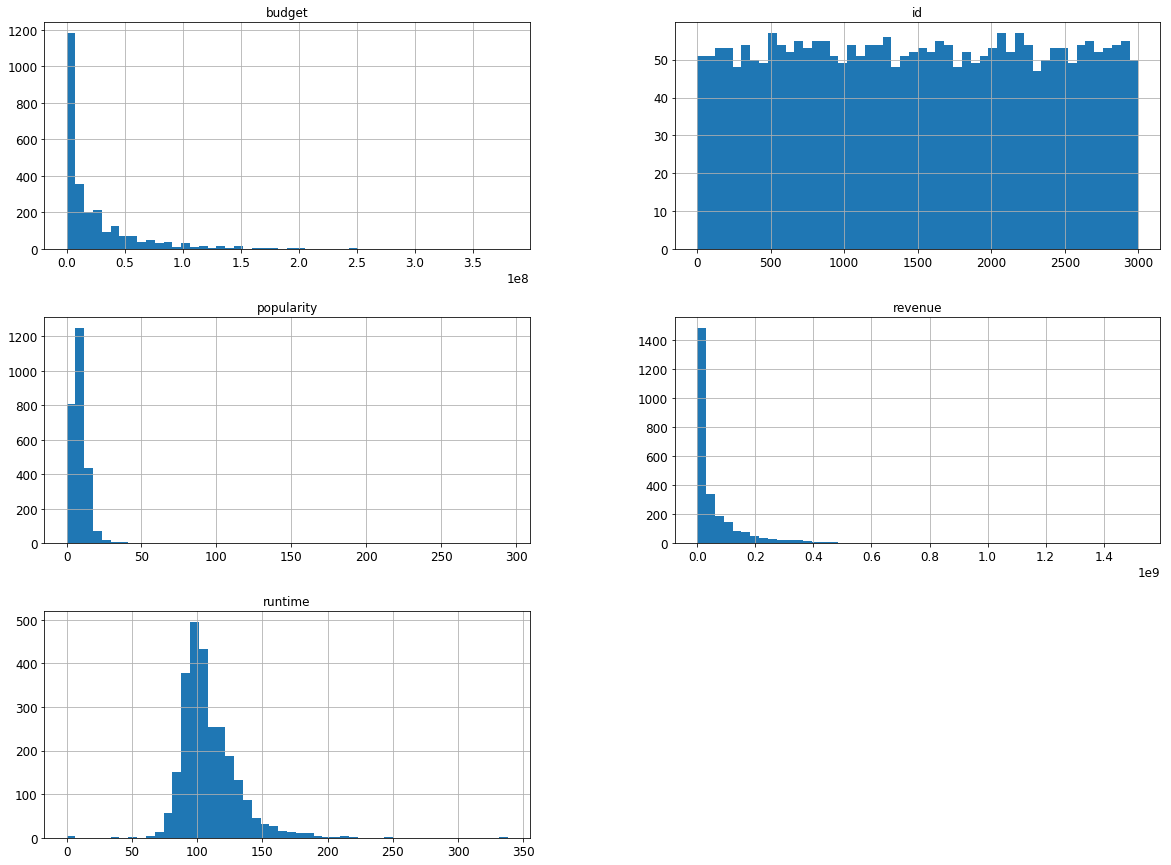

In [271]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [272]:
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

In [273]:
import datetime
dt = datetime.datetime.now().date()
data['age'] = dt - pd.to_datetime(data['release_date']).dt.date 
#data['age'].apply(lambda x:x.toordinal())
data['age'] = data.age.dt.days

In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2622 entries, 0 to 2999
Data columns (total 15 columns):
id                      2622 non-null int64
budget                  2622 non-null int64
genres                  2622 non-null object
original_language       2622 non-null object
popularity              2622 non-null float64
production_companies    2622 non-null object
production_countries    2622 non-null object
release_date            2622 non-null datetime64[ns]
runtime                 2622 non-null float64
spoken_languages        2622 non-null object
status                  2622 non-null object
title                   2622 non-null object
Keywords                2622 non-null object
revenue                 2622 non-null int64
age                     2622 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(8)
memory usage: 327.8+ KB


In [275]:
corr_matrix = data.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue       1.000000
budget        0.747999
popularity    0.449099
runtime       0.218760
id            0.000905
age          -0.021222
Name: revenue, dtype: float64

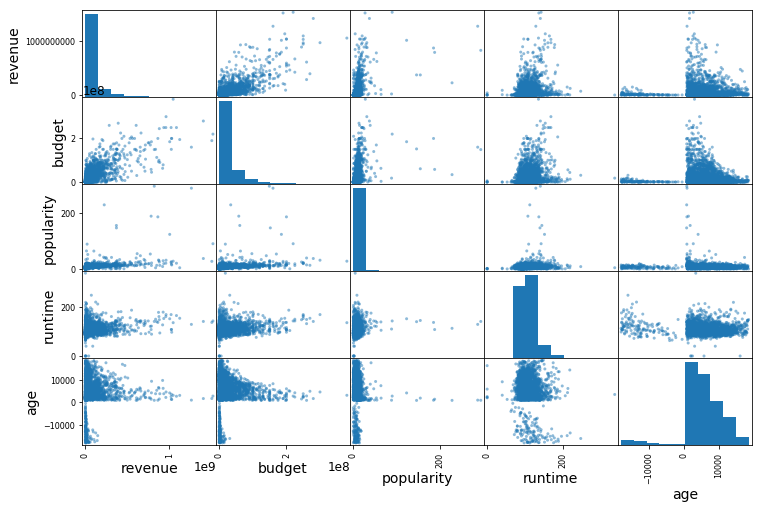

In [276]:
from pandas.plotting import scatter_matrix

# Top four correlated inputs with survived
attributes = ["revenue", "budget", "popularity", "runtime", "age"]
scatter_matrix(data[attributes], figsize=(12, 8));

## Preprocessing


In [277]:
from ast import literal_eval
data.loc[:,'genres'] = data.loc[:,'genres'].apply(lambda x: literal_eval(x))
data.loc[:,'Keywords'] = data.loc[:,'Keywords'].apply(lambda x: literal_eval(x))
data.loc[:,'production_countries'] = data.loc[:,'production_countries'].apply(lambda x: literal_eval(x))
data.loc[:,'spoken_languages'] = data.loc[:,'spoken_languages'].apply(lambda x: literal_eval(x))

In [278]:
data.loc[:,'production_companies'] = data.loc[:,'production_companies'].apply(lambda x: literal_eval(x))
data['prod_company_new'] = data.apply(lambda row: row.production_companies[0]['name'], axis=1)

In [279]:
data['genre_new'] = data.apply(lambda row: row.genres[0]['name'], axis=1)
data['Keywords_new'] = data.apply(lambda row: row.Keywords[0]['name'], axis=1)
data['production_countries_new'] = data.apply(lambda row: row.production_countries[0]['name'], axis=1)
data['spoken_lang_new'] = data.apply(lambda row: row.spoken_languages[0]['name'], axis=1)

In [280]:
class TitleAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        df = pd.DataFrame(X, columns=self.features)
        #df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
        # Apply the necessary transformations to obtain the 5 title categories
        # (Mr, Mrs, Miss, Master, Other) like it was done in section 5.1.2
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        
        import datetime
        dt = datetime.datetime.now().date()
        data['age'] = dt - pd.to_datetime(data['release_date']).dt.date 
        #data['age'].apply(lambda x:x.toordinal())
        data['age'] = data.age.dt.days
        
    
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#
        #df.drop('Name', axis=1, inplace=True)
        return np.array(df.values)

## Modeling

In [281]:
#from sklearn.model_selection import train_test_split

#train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

In [282]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2622 entries, 0 to 2999
Data columns (total 20 columns):
id                          2622 non-null int64
budget                      2622 non-null int64
genres                      2622 non-null object
original_language           2622 non-null object
popularity                  2622 non-null float64
production_companies        2622 non-null object
production_countries        2622 non-null object
release_date                2622 non-null datetime64[ns]
runtime                     2622 non-null float64
spoken_languages            2622 non-null object
status                      2622 non-null object
title                       2622 non-null object
Keywords                    2622 non-null object
revenue                     2622 non-null int64
age                         2622 non-null int64
prod_company_new            2622 non-null object
genre_new                   2622 non-null object
Keywords_new                2622 non-null object
produ

In [283]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer

# Identify the numeric features we wish to consider. 
num_attribs = [
    'budget', 
    'popularity',
    'runtime',
    'age'
]
# Create a pipeline for the numeric features.
# Use DataFrameSelector with the numeric features defined above
# Use StandardScaler() to standardize the data
# Missing values will be imputed using the feature median.
#==================================================#
#               Your code starts here              #
#==================================================#      
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#


# Identify the categorical features we wish to consider.
cat_attribs = [
    "genre_new", 
    "Keywords_new",
    "production_countries_new",
    "prod_company_new",
    "original_language",
    "spoken_lang_new"
]
# Identiy the range of expected values for the categorical features.
#cat_values = [
    #['S','C','Q'],     # Embarked
    #['female','male'], # Sex
    #[1,2,3] # Pclass
#]
# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

# Union the transformed, scaled numeric and categorical features.
#==================================================#
#               Your code starts here              #
#==================================================#

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#



## Evaluation, reporting and analysis


In [293]:
y = data['revenue']
x = data.drop(['revenue', 'genres', 'release_date','production_companies','production_countries','spoken_languages', 'Keywords', 'title'], axis = 1)

In [294]:
x.head()

,id,budget,original_language,popularity,runtime,status,age,prod_company_new,genre_new,Keywords_new,production_countries_new,spoken_lang_new
0,1,14000000,en,6.575393,93.0,Released,1712,Paramount Pictures,Comedy,time travel,United States of America,English
1,2,40000000,en,8.248895,113.0,Released,5562,Walt Disney Pictures,Comedy,coronation,United States of America,English
2,3,3300000,en,64.299990,105.0,Released,1845,Bold Films,Drama,jazz,United States of America,English
8,9,0,en,6.902423,100.0,Released,8656,Walt Disney Pictures,Action,island,United States of America,English
9,10,6000000,en,4.672036,91.0,Released,6040,Castle Rock Entertainment,Comedy,mockumentary,United States of America,English


In [295]:
# use full pipeline above to build full pipeline with predictor
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("Linear Regression", LinearRegression())
    ])

# split 20% test data with random seed set to 42 for correct results
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=42)

In [296]:
y.head()

0    12314651
1    95149435
2    13092000
8    34327391
9    18750246
Name: revenue, dtype: int64

In [299]:
start = time()
full_pipeline_with_predictor.fit(x_train, y_train)
np.random.seed(42)

# Set up cross validation scores 
# Use ShuffleSplit() with 30 splits, 30% test_size 
# and a random seed of 0
#==================================================#
#               Your code starts here              #
#==================================================#
cv30Splits = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
#logit_scores = cross_val_score()        
logit_scores = cross_val_score(full_pipeline_with_predictor, x_train, y_train,
                         scoring = None , cv=cv30Splits)
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(x_test, y_test)
test_time = np.round(time() - start, 4)

In [300]:
results.loc[0] = ["Baseline_IMDB", pct(logit_score_train), np.round(pct(logit_score_test),3), 
                  "---", train_time, test_time, "Untuned LogisticRegression"]
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline_IMDB,-5.653732e+24,-8.348607e+21,---,49.4268,0.033,Untuned LogisticRegression


In [261]:
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        (
        'Linear Regression', LinearRegression()),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Naive Bayes', GaussianNB()),
        #('Support Vector', SVC(random_state=42))
        #('Stochastic GD', SGDClassifier(random_state=42))
        ('RandomForest', RandomForestClassifier())
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Logistic Regression': {
            'penalty': ('l1', 'l2'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'C': (10, 1, 0.1, 0.01)
        },
         'K-Nearest Neighbors': {
            'n_neighbors': (3, 5, 7, 8, 11),
            'p': (1,2)
        },
        'Naive Bayes': {},
       # 'Support Vector' : {
        #    'kernel': ('rbf', 'poly'),     
         #   'degree': (1, 2, 3, 4, 5),
         #   'C': (10, 1, 0.1, 0.01),
       # },
         #'Stochastic GD': {
           # 'loss': ('hinge', 'perceptron', 'log'),
           # 'penalty': ('l1', 'l2', 'elasticnet'),
            #'tol': (0.0001, 0.00001, 0.0000001), 
            #'alpha': (0.1, 0.01, 0.001, 0.0001), 
       # }
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]}
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring='accuracy', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(x_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        # To calculate the best_train_accuracy use the pct() and mean() methods
        #==================================================#
        #               Your code starts here              #
        #==================================================#
        #best_train_scores = cross_val_score( ...., cv=cv30Splits)
        best_train_scores = cross_val_score(grid_search.best_estimator_ ,x_train, y_train, cv=cv30Splits)
        best_train_accuracy = pct(best_train_scores.mean())     
        #==================================================#
        #               Your code ends here                #
        #               Please don't add code below here   #
        #==================================================#    
       
        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,5), train_time, test_time, json.dumps(param_dump)]

In [262]:
%%time
# This might take a while
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    ConductGridSearch(x_train, y_train, x_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01)
	penalty: ('l1', 'l2')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [172]:
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,-2.079853e+18,0.0,---,185.2979,0.0850,Untuned LogisticRegression
1,Best Model:Logistic Regression,3.000000e-01,0.4,0,5.6392,0.1570,"[[""predictor__C"", 0.1], [""predictor__penalty"",..."
2,Best Model:K-Nearest Neighbors,0.000000e+00,0.0,0,0.2107,4.7370,"[[""predictor__n_neighbors"", 3], [""predictor__p..."
3,Best Model:Naive Bayes,1.000000e-01,0.0,0,0.3280,43.9703,[]
4,Best Model:RandomForest,3.000000e-01,0.4,0,0.2170,0.2220,"[[""predictor__bootstrap"", false], [""predictor_..."


In [ ]:
y_test_final = test_data['revenue']
x_test_final = test_data.drop(['revenue', 'genres','production_companies','production_countries','spoken_languages', 'Keywords', 'title'], axis = 1)

In [ ]:
start = time()
full_pipeline_with_predictor.fit(x_test_final, y_test_final)
np.random.seed(42)

# Set up cross validation scores 
# Use ShuffleSplit() with 30 splits, 30% test_size 
# and a random seed of 0
#==================================================#
#               Your code starts here              #
#==================================================#
cv30Splits = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
#logit_scores = cross_val_score()        
logit_scores = cross_val_score(full_pipeline_with_predictor, x_train, y_train,
                         scoring="neg_mean_squared_error", cv=cv30Splits)
#==================================================#
#               Your code ends here                #
#               Please don't add code below here   #
#==================================================#
logit_score_train = logit_scores.mean()
train_time = np.round(time() - start, 4)

# Time and score test predictions
start = time()
logit_score_test  = full_pipeline_with_predictor.score(x_test, y_test)
test_time = np.round(time() - start, 4)

In [174]:
results.loc[0] = ["Final", pct(logit_score_train), np.round(pct(logit_score_test),3), 
                  "---", train_time, test_time, "LogisticRegression"]
results

,ExpID,Cross fold train accuracy,Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
0,Final,-2.079853e+18,0.0,---,185.2979,0.0850,LogisticRegression
1,Best Model:Logistic Regression,3.000000e-01,0.4,0,5.6392,0.1570,"[[""predictor__C"", 0.1], [""predictor__penalty"",..."
2,Best Model:K-Nearest Neighbors,0.000000e+00,0.0,0,0.2107,4.7370,"[[""predictor__n_neighbors"", 3], [""predictor__p..."
3,Best Model:Naive Bayes,1.000000e-01,0.0,0,0.3280,43.9703,[]
4,Best Model:RandomForest,3.000000e-01,0.4,0,0.2170,0.2220,"[[""predictor__bootstrap"", false], [""predictor_..."


## Kaggle Submission


In [301]:
test_data = pd.read_csv('datasets/TMDB/test.csv')

In [302]:
test_data.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."
